# WAMIDA Statistical Analysis

## Author: Ricky Hu

This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables. Categorical variables are changed into dummy variables for binary categories.

**2. Exploratory Data Analysis**

We can conduct a wilcoxon test for continuous data and fisher exact test for binary data. We can also compute Pearson correlation coefficients as well. Note that the p-values are not representative of how significant a logistic fit is (this is what we really want in the end), but this can allow us to be exploratory to see which variables are very viable or very unviable for logistic regression fit.

**3. Logistic Regression, Refactoring Low Significance Variables and Re-fitting**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported along with P-value The high-p variables are removed and then logistic regression is re-fitted to achieve a higher accruacy fit. Odds ratios can then be reported.

# 1. Preprocessing

In [62]:
# Setup, imports

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn
from scipy.stats import wilcoxon, pearsonr
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = [40, 20]

In [71]:
data = pd.read_excel('data_input.xlsx')
#dropping one subject due to low variance
data = data.drop(index = 73)
data = data.drop(columns = 'Study ID')
#Age has a space afterward in the spreadsheet,
cols_num = ['Age ', 'Pack Years', 'Drinks/Week', 'BMI', 'HADS D', 'HADS A']
data_num = data[cols_num]
data_cat = data.drop(columns = cols_num)
print(data.columns)

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'HADS D', 'HADS A', 'Depression Threshold',
       'Anxiety Threshold'],
      dtype='object')


# Exploratory Data Analysis

## Testing Colinearity with Variance Inflation Factor, colinear variables would not be of statistical value and would be removed for a regression fit 


In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = data.iloc[:,:-4]
calc_vif(X)


,variables,VIF
0,Age,18.465814
1,Sex,5.106580
2,Education Level,2.714635
3,Employment,2.797266
4,Income (2019),4.195509
5,Marital Status,4.673924
6,House Situation,3.686119
7,Pack Years,2.848959
8,Drinks/Week,1.511119
9,Hx Depression,2.480566


## As expected, BMI is colinear with height and weight, Rooms and people measure are also colinear. We can then remove the colinear variables (these variables have been removed from the input data as of Oct 4, 2020 but can be re-added to demonstrate this concept)

## We can visualize pearson correlation of the with a correlation matrix 

## (Colinear variables remaining for completeness, will be removed for regression fitting)

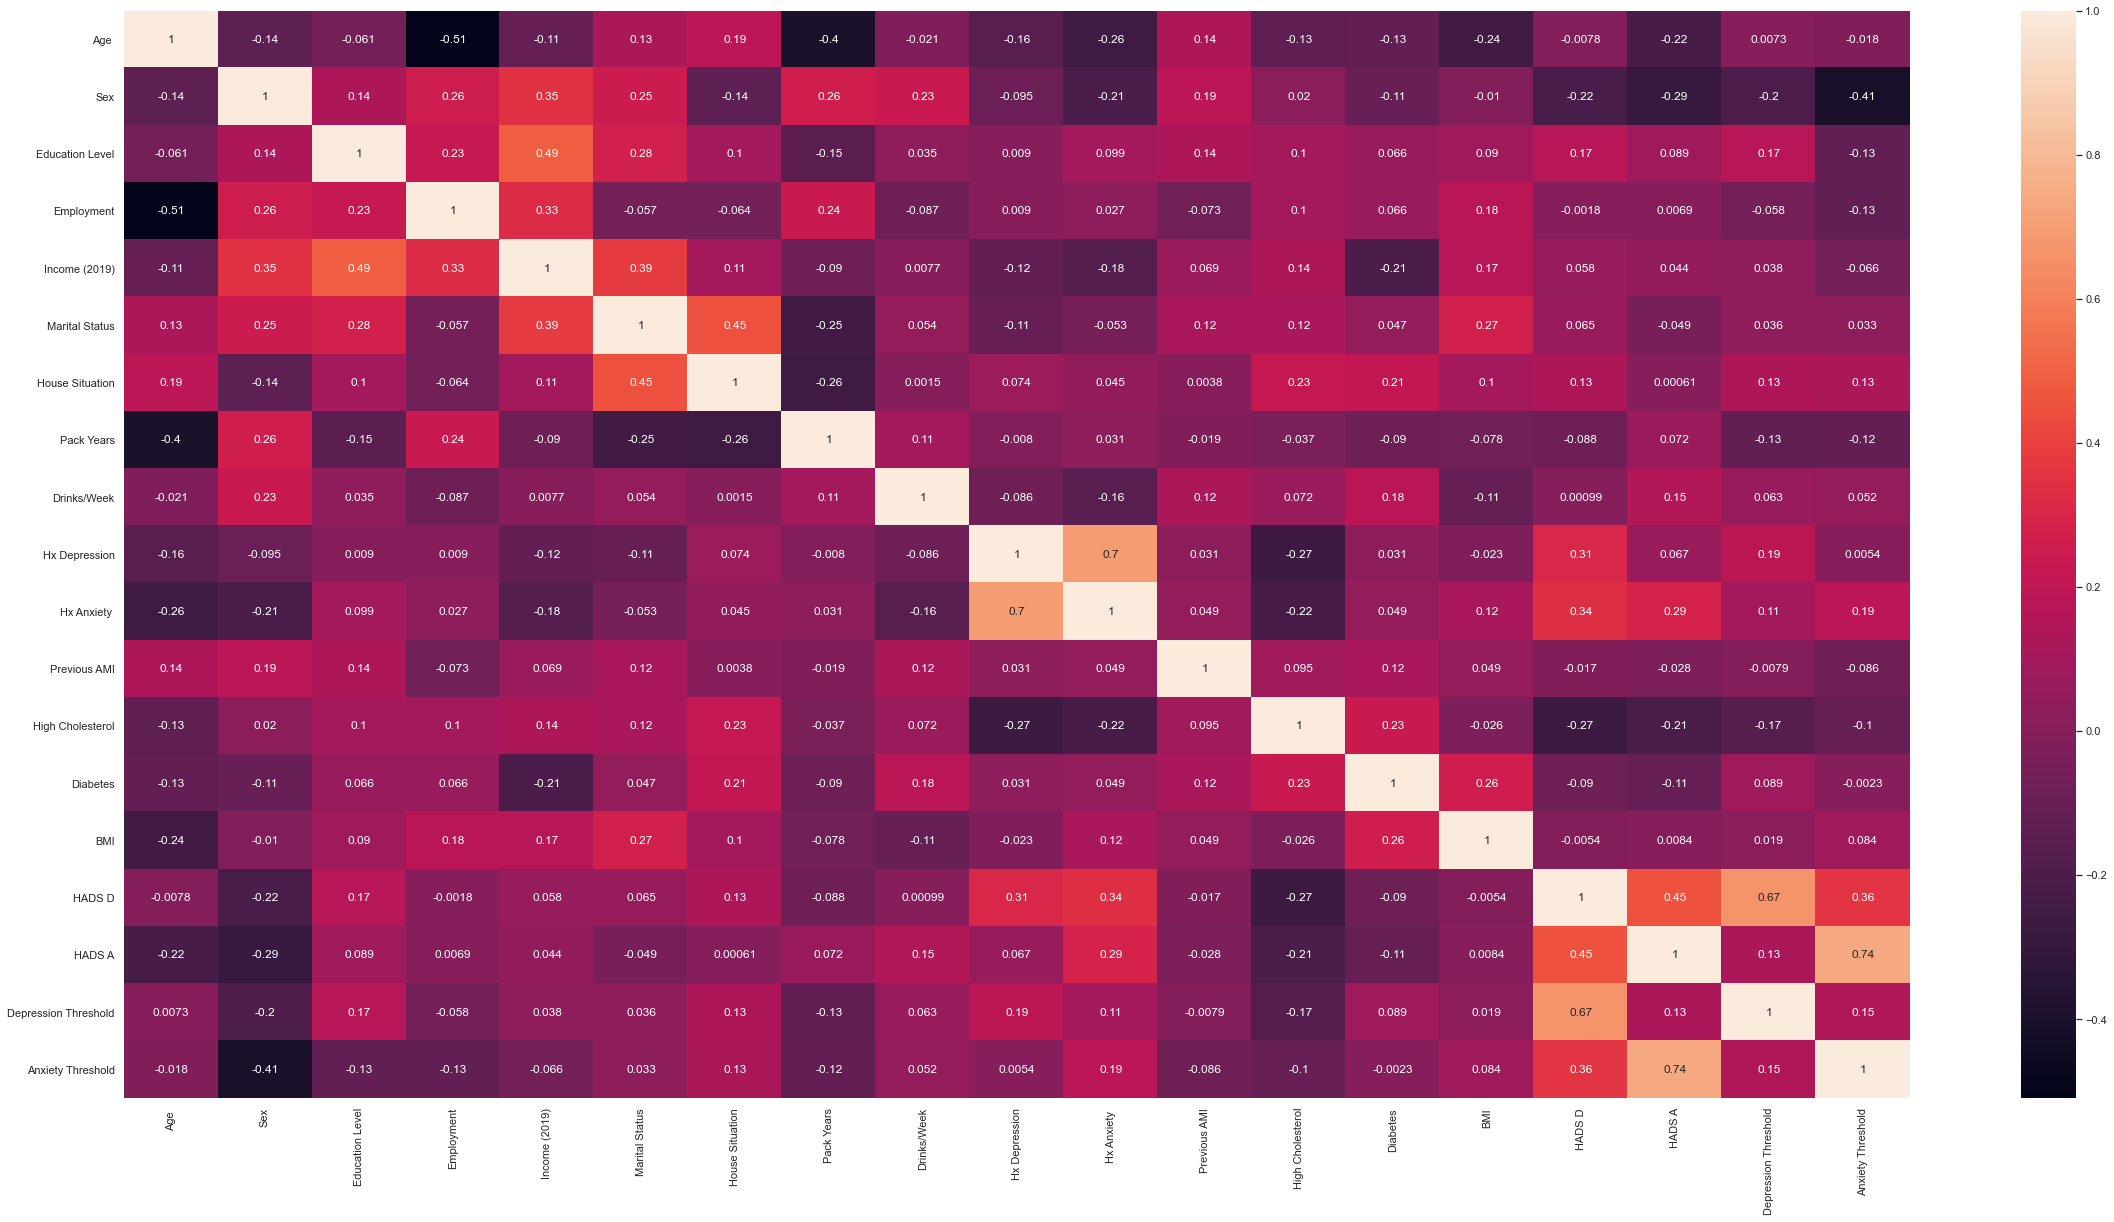

In [72]:
corrMatrix = data.corr()
fig = sn.heatmap(corrMatrix, annot=True)
plt.show()

In [73]:
corrMatrix

,Age,Sex,Education Level,Employment,Income (2019),Marital Status,House Situation,Pack Years,Drinks/Week,Hx Depression,Hx Anxiety,Previous AMI,High Cholesterol,Diabetes,BMI,HADS D,HADS A,Depression Threshold,Anxiety Threshold
Age,1.000000,-0.140993,-0.060719,-0.509534,-0.110546,0.128761,0.190039,-0.397942,-0.021486,-0.162566,-0.259269,0.136792,-0.134305,-0.126216,-0.244885,-0.007818,-0.222384,0.007349,-0.018227
Sex,-0.140993,1.000000,0.138587,0.255126,0.346410,0.251078,-0.138587,0.264181,0.234587,-0.095482,-0.211174,0.187252,0.020315,-0.107571,-0.009964,-0.218668,-0.285829,-0.197386,-0.407478
Education Level,-0.060719,0.138587,1.000000,0.229167,0.490990,0.276287,0.101190,-0.149250,0.035470,0.009022,0.098802,0.135526,0.101886,0.065881,0.090056,0.172897,0.088952,0.172005,-0.127150
Employment,-0.509534,0.255126,0.229167,1.000000,0.327327,-0.057059,-0.063988,0.235869,-0.087203,0.009022,0.027122,-0.073410,0.101886,0.065881,0.182191,-0.001799,0.006858,-0.058026,-0.127150
Income (2019),-0.110546,0.346410,0.490990,0.327327,1.000000,0.385337,0.109109,-0.089994,0.007717,-0.124035,-0.177555,0.069007,0.135333,-0.207020,0.168719,0.057698,0.044368,0.037987,-0.065653
Marital Status,0.128761,0.251078,0.276287,-0.057059,0.385337,1.000000,0.445964,-0.249244,0.053634,-0.113798,-0.052780,0.117759,0.120687,0.047484,0.269458,0.064657,-0.048847,0.035549,0.032527
House Situation,0.190039,-0.138587,0.101190,-0.063988,0.109109,0.445964,1.000000,-0.257954,0.001526,0.074433,0.044558,0.003765,0.225920,0.212701,0.100543,0.134900,0.000605,0.134703,0.127150
Pack Years,-0.397942,0.264181,-0.149250,0.235869,-0.089994,-0.249244,-0.257954,1.000000,0.107863,-0.007984,0.030627,-0.019017,-0.036612,-0.089906,-0.078214,-0.088421,0.071578,-0.128576,-0.120539
Drinks/Week,-0.021486,0.234587,0.035470,-0.087203,0.007717,0.053634,0.001526,0.107863,1.000000,-0.086149,-0.162649,0.122153,0.072430,0.183728,-0.111797,0.000994,0.154109,0.063249,0.051807
Hx Depression,-0.162566,-0.095482,0.009022,0.009022,-0.124035,-0.113798,0.074433,-0.007984,-0.086149,1.000000,0.697395,0.031384,-0.269695,0.031384,-0.023479,0.305004,0.067261,0.193179,0.005429


In [74]:
outMat = corrMatrix[['HADS D', 'HADS A', 'Depression Threshold', 'Anxiety Threshold']].copy()
outMat


,HADS D,HADS A,Depression Threshold,Anxiety Threshold
Age,-0.007818,-0.222384,0.007349,-0.018227
Sex,-0.218668,-0.285829,-0.197386,-0.407478
Education Level,0.172897,0.088952,0.172005,-0.127150
Employment,-0.001799,0.006858,-0.058026,-0.127150
Income (2019),0.057698,0.044368,0.037987,-0.065653
Marital Status,0.064657,-0.048847,0.035549,0.032527
House Situation,0.134900,0.000605,0.134703,0.127150
Pack Years,-0.088421,0.071578,-0.128576,-0.120539
Drinks/Week,0.000994,0.154109,0.063249,0.051807
Hx Depression,0.305004,0.067261,0.193179,0.005429


In [87]:
# computing p values as well
corrData = []
for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['HADS A'])
    corrData.append([cols, r, p])

for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['HADS D'])
    corrData.append([cols, r, p])


for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['Anxiety Threshold'])
    corrData.append([cols, r, p])

for cols in data.columns:
    (r,p) = pearsonr(data[cols], data['Depression Threshold'])
    corrData.append([cols, r, p])

pd.set_option('display.max_rows', None)
corrDF = pd.DataFrame(corrData, columns = ['Var', 'r','p'])
print(corrDF)

                     Var         r             p
0                   Age  -0.222384  5.686189e-02
1                    Sex -0.285829  1.356143e-02
2        Education Level  0.088952  4.510517e-01
3             Employment  0.006858  9.537559e-01
4          Income (2019)  0.044368  7.073975e-01
5         Marital Status -0.048847  6.793912e-01
6        House Situation  0.000605  9.959174e-01
7             Pack Years  0.071578  5.444940e-01
8            Drinks/Week  0.154109  1.898672e-01
9          Hx Depression  0.067261  5.690890e-01
10           Hx Anxiety   0.289638  1.231294e-02
11          Previous AMI -0.028065  8.123748e-01
12      High Cholesterol -0.210555  7.175422e-02
13              Diabetes -0.113027  3.376513e-01
14                   BMI  0.008403  9.433501e-01
15                HADS D  0.454539  4.737845e-05
16                HADS A  1.000000  0.000000e+00
17  Depression Threshold  0.128652  2.746528e-01
18     Anxiety Threshold  0.740602  4.628420e-14
19                  

## We are interested in the correlation to the binary Anxiety or Depression calculation, so we will extract correlations from those rows

In [45]:
corrMatrix['Bin Anx']

Age                -0.016217
Sex                -0.402819
Education Level    -0.113287
Employment         -0.127150
Income (2019)      -0.051477
Marital Status      0.032527
House Situation     0.127150
Pack Years         -0.117683
Drinks/Week         0.064493
Hx Depression       0.005429
Hx Anxiety          0.188845
Previous AMI       -0.086080
High Cholesterol   -0.103067
Diabetes           -0.019862
BMI                 0.076413
HADS D              0.356828
HADS A              0.740602
Bin Dep             0.149638
Bin Anx             1.000000
Name: Bin Anx, dtype: float64

In [46]:
corrMatrix['Bin Dep']

Age                 0.008907
Sex                -0.199625
Education Level     0.184158
Employment         -0.058026
Income (2019)       0.049298
Marital Status      0.035549
House Situation     0.134703
Pack Years         -0.126210
Drinks/Week         0.073523
Hx Depression       0.193179
Hx Anxiety          0.106567
Previous AMI       -0.007864
High Cholesterol   -0.167593
Diabetes            0.072784
BMI                 0.013071
HADS D              0.665834
HADS A              0.128652
Bin Dep             1.000000
Bin Anx             0.149638
Name: Bin Dep, dtype: float64

## As a preliminary analysis, we can see there are some variables that show some correlation, but the correlation is weak for the most part. This may suggestion that the relationship between the variables to the outcome is nonlinear and linear correlation analysis is insufficient.

## We can do some Biostat faves and look at Wilcoxon values for continuous (comparing to HADS A and HADS D, quasi-continuous, really, since it's all integer data) and Fisher values (comparing to 0/1 of depression or no depression) for binary data. 

In [47]:
print('Wilcoxon p values for continuous data, compared to HADS A score:')
for cols in data_num.columns:
    if cols != 'HADS A':
        w, p = wilcoxon(data_num[cols],data_num['HADS A'])
        print(cols, ': ', p)

    
print('\nWilcoxon p values for continuous data compared to HADS D score:')
for cols in data_num.columns:
    if cols != 'HADS D':
        w, p = wilcoxon(data_num[cols],data_num['HADS D'])
        print(cols, ': ', p)

Wilcoxon p values for continuous data, compared to HADS A score:
Age  :  7.654968486537892e-14
Pack Years :  1.991423338398885e-09
Drinks/Week :  0.9268941263731648
BMI :  7.731138702428815e-14
HADS D :  0.009638079112264988

Wilcoxon p values for continuous data compared to HADS D score:
Age  :  7.661289240756902e-14
Pack Years :  8.820013263607202e-10
Drinks/Week :  0.5981990266542923
BMI :  7.731935839492253e-14
HADS A :  0.009638079112264988


## P-values look okay, but don't get too excited - the low-sample size may throw off the wilcoxon algorithm. The logistic regression p-value is what we really want to look at (later on)

## For the binary variables, we use Fisher's Exact Test. First, we need to convert categories into binary dummy variables

## Categorical variables converted to dummy variables with binary values (not needed after the exclusion of these variables, but may use this code later on - code is commented out for now)

In [38]:
#cat_vars = ['Sex', 'Education Level', 'Employment', 'Income (2019)', 'Married', 'House Situation', 'Ethnicity',\
#           'People in House', 'Rooms in House','Rooms per Person', 'Pre-COVID Anxiety about Health', \
#           'Post-COVID Anxiety about Health']
#cont_vars = data_cont.columns
#data2 = data
#for var in cat_vars:
#    cat_list='var'+'_'+var
#    cat_list = pd.get_dummies(data[var], prefix=var)
#    data2=data2.join(cat_list)

#data3 = data2.drop(columns=cat_vars)
#data3 = data3.drop(columns=['Study ID'])
#data3 = data3.drop(columns = cont_vars)
#data3.columns

# We have to create contingency tables for each variables with respect to the outcome (binary anxiety or binary depression outcomes), then compute the Fisher exact test p-value

In [48]:
data_cat

,Sex,Education Level,Employment,Income (2019),Marital Status,House Situation,Hx Depression,Hx Anxiety,Previous AMI,High Cholesterol,Diabetes,Bin Dep,Bin Anx
0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,1,0,0,0,0,0,1,0,0,0,0
2,1,1,0,1,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,0,0,0
4,0,1,1,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,1,0,0,1,1,1,1,1,0,0,0,0
70,1,0,1,1,1,0,0,0,0,0,0,0,0
71,0,1,0,0,0,1,0,1,1,1,1,0,0
72,1,1,0,0,1,1,0,0,0,1,0,0,0


In [49]:
print('Fisher exact test for anxiety')
for cols in data_cat.columns:
    if cols != 'Bin Anx':
        data_crosstab = pd.crosstab(data_cat[cols],data_cat['Bin Anx'])
        oddsratio, pvalue = stats.fisher_exact(data_crosstab)
        print(cols, ': \t' ,pvalue)

print('\nFisher exact test for depression')
for cols in data_cat.columns:
    if cols != 'Bin Dep':
        data_crosstab = pd.crosstab(data_cat[cols],data_cat['Bin Dep'])
        oddsratio, pvalue = stats.fisher_exact(data_crosstab)
        print(cols, ': \t' ,pvalue)

Fisher exact test for anxiety
Sex : 	 0.0016185726106290564
Education Level : 	 0.39404227013777315
Employment : 	 0.39404227013777315
Income (2019) : 	 0.7783867210432049
Marital Status : 	 1.0
House Situation : 	 0.3940422701377734
Hx Depression : 	 1.0
Hx Anxiety  : 	 0.1381958424067381
Previous AMI : 	 0.7203794495063713
High Cholesterol : 	 0.4113847358496052
Diabetes : 	 1.0
Bin Dep : 	 0.23773240760053616

Fisher exact test for depression
Sex : 	 0.15907142010130862
Education Level : 	 0.1906798704267813
Employment : 	 0.7472678682958249
Income (2019) : 	 1.0
Marital Status : 	 1.0
House Situation : 	 0.3307407808539726
Hx Depression : 	 0.12508333642880048
Hx Anxiety  : 	 0.39591672049953686
Previous AMI : 	 1.0
High Cholesterol : 	 0.19801808012342048
Diabetes : 	 0.42562573424546396
Bin Anx : 	 0.23773240760053538


## p-values are all over the place, especially for the binary variables likely due to low frequency and the algorithm thinks it's all due to chance, with the exception of a few variables. LIkely more samples are needed to elicit a meaningful Fisher test

## 3. Initial Attempt at Logistic Regression

## First removing colinear variables, similar to above. Note that categorical variables are not defined for VIF, colinearity is not well understood for those

In [4]:
data_final = data.drop(columns=['HADS D','HADS A'])
data_final.columns

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')

## Removing low-variance variables

In [5]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
X = data_final
min_variance = 0.1
high_var_cols = variance_threshold_selector(X, min_variance) 
print('columns remaining: ', high_var_cols.columns )
print(len(high_var_cols.columns))
X_low_var_removed = data_final[high_var_cols.columns]
X_low_var_removed.columns

columns remaining:  Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')
17


Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI', 'Bin Dep', 'Bin Anx'],
      dtype='object')

# Now that no remaining variables are colinear, we can begin regression

# For Anxiety:

In [6]:
import statsmodels.api as sm

# for Anxiety
y = data_final['Bin Anx']
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.351484
         Iterations 7
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.327   
Dependent Variable:  Bin Anx          AIC:              82.0196 
Date:                2020-10-04 00:28 BIC:              116.5806
No. Observations:    74               Log-Likelihood:   -26.010 
Df Model:            14               LL-Null:          -38.634 
Df Residuals:        59               LLR p-value:      0.032198
Converged:           1.0000           Scale:            1.0000  
No. Iterations:      7.0000                                     
----------------------------------------------------------------
    

# Refactoring variables and repeating logistic regression fit

## P values are not very good, this is most likely due to undersampling (rule of thumb is 10x the number of variables needed as a sample size). What we can do is remove the very low statistical power variables and re-fit

In [21]:
low_sig_cols = ['Age ', 'Employment', 'House Situation', 'Marital Status',\
                'Diabetes', 'Previous AMI', 'Pack Years','BMI']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())


Index(['Sex', 'Education Level', 'Income (2019)', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'High Cholesterol'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.371441
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.289    
Dependent Variable: Bin Anx          AIC:              68.9733  
Date:               2020-10-04 01:04 BIC:              85.1017  
No. Observations:   74               Log-Likelihood:   -27.487  
Df Model:           6                LL-Null:          -38.634  
Df Residuals:       67               LLR p-value:      0.0010709
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------

## Repeating the same but with depression instead of anxiety

In [22]:
y = data_final['Bin Dep']
X = data_final.drop(columns = ['Bin Anx', 'Bin Dep'])

print(X.columns)
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Index(['Age ', 'Sex', 'Education Level', 'Employment', 'Income (2019)',
       'Marital Status', 'House Situation', 'Pack Years', 'Drinks/Week',
       'Hx Depression', 'Hx Anxiety ', 'Previous AMI', 'High Cholesterol',
       'Diabetes', 'BMI'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.312592
         Iterations 8
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.256   
Dependent Variable:  Bin Dep          AIC:              76.2635 
Date:                2020-10-04 01:04 BIC:              110.8245
No. Observations:    74               Log-Likelihood:   -23.132 
Df Model:            14               LL-Null:          -31.106 
Df Residuals:        59               LLR p-value:      0.31647 
Converged:           1.0000           Scale:            1.0000  
No. Iterations:      8.0000                                     
----------------------------------------------------------------
    

In [28]:
low_sig_cols = ['Employment',  'Marital Status','House Situation', 'Pack Years', 'Diabetes', 'BMI',\
                'Previous AMI', 'Hx Anxiety ']
X2 = X.drop(columns=low_sig_cols)
print(X2.columns)
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())

Index(['Age ', 'Sex', 'Education Level', 'Income (2019)', 'Drinks/Week',
       'Hx Depression', 'High Cholesterol'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.341599
         Iterations 7
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.187   
Dependent Variable:  Bin Dep          AIC:              64.5566 
Date:                2020-10-04 01:15 BIC:              80.6851 
No. Observations:    74               Log-Likelihood:   -25.278 
Df Model:            6                LL-Null:          -31.106 
Df Residuals:        67               LLR p-value:      0.070090
Converged:           1.0000           Scale:            1.0000  
No. Iterations:      7.0000                                     
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Age


## We see some variables achieving a statistically significant maximum likelihood fit as well.



## There are some decent takeaways from the results so far:

1. Sex was the most statistically significant in logistic regression modelling with a high odds ratio. Otherwise, anxiety and depression had different variables that were stat. significant <0.05. The odds ratio can be observed by the Coefficient column.

2. Variables with expected biological plausibility (e.g. Hx depression, Hx anxiety - which showed strong linear correlation in the pearson correlation calculations) were not statistically significant in the regression fit. However, we cannot conclude these are clinically insignificant. Rather, this motivates further data collection to acquire sufficient samples to have sufficient statistical power to analyze these variables. Ideally 170+ data points as there are 17 relevant variables

3. Many variables had to be excluded in the logistic regression step (variables excluded in the VIF step should be excluded regardless) due to low sample size compared to the number of variables. The rule of thumb is # of samples > 10(# of variables) for logistic regression and hence the exclusion process was necessary, done based on intial p-value ranking. To improve the model, more samples are needed.

4. If you want something super advanced, I would suggest using a random forest for some machine learning-level complexity (logistic regression is a form of ML, but the simplest model). But again, more data is required for this.


# TL;DR - model is showing some promise (sex is significant with clin. significant odds ratio), but more data is needed for statistical power in the logistic regression modelling